# 13 주식 예측 도전

## 13.1 시계열 데이터 준비(NIVIDIA)

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/NVDA.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
1999-01-22    1.640625
1999-01-25    1.812500
1999-01-26    1.671875
1999-01-27    1.666667
1999-01-28    1.661458
Name: Close, dtype: float64

## 13.2 각종 전처리 수행

### 13.2.1 결측치 처리

In [2]:
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

### 13.2.2 로그변환

In [3]:
ts_log = np.log(ts)

## 13.3 시계열 안정성 분석
-정성적 그래프 분석  
-정량적 Augmented Dicky-Fuller Test  
-시계열 분해(Time Series Decomposition)  
-Residual 안정성 확인

### 13.3.1 정성적 그래프 분석

In [4]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

### 13.3.2 정량적 Augmented Dicky-Fuller Test

In [5]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

### 13.3.3 시계열 분해 그래프 분석

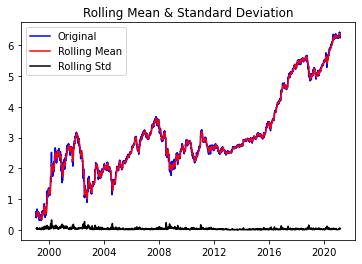

Results of Dickey-Fuller Test:
Test Statistic                   -0.580786
p-value                           0.875265
#Lags Used                       24.000000
Number of Observations Used    5539.000000
Critical Value (1%)              -3.431531
Critical Value (5%)              -2.862062
Critical Value (10%)             -2.567048
dtype: float64


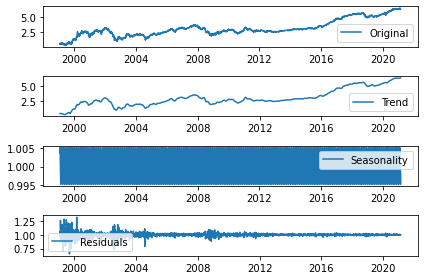

In [6]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### 13.3.4 Residual 안정성 확인

In [7]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.818648e+01
p-value                        2.425476e-30
#Lags Used                     3.300000e+01
Number of Observations Used    5.500000e+03
Critical Value (1%)           -3.431540e+00
Critical Value (5%)           -2.862066e+00
Critical Value (10%)          -2.567050e+00
dtype: float64


## 13.4 학습, 테스트 데이터셋 생성

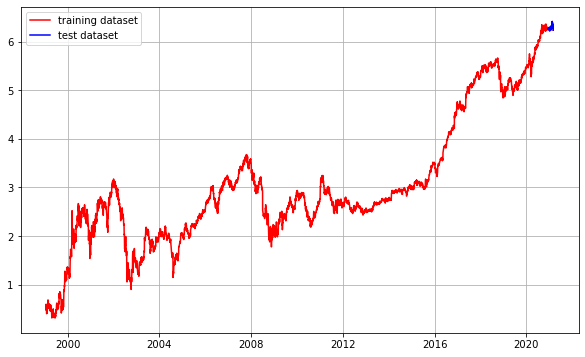

In [8]:
#학습, 테스트 데이터셋 분리

train_data, test_data = ts_log[:int(len(ts_log)*0.99)], ts_log[int(len(ts_log)*0.99):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 13.5 적정ARIMA모수 찾기

### 13.5.1 ACF, PACF 그려보기(p,q구하기)

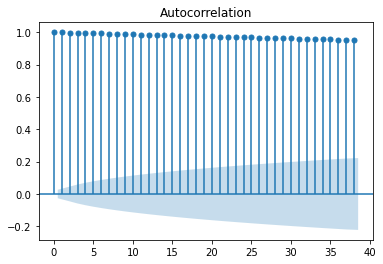

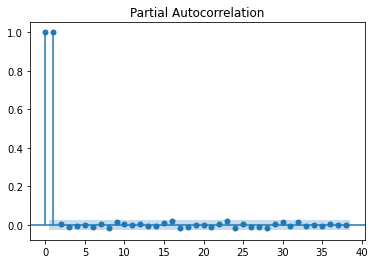

In [9]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### 13.5.2 차분 안정성 확인(d 구하기)

Results of Dickey-Fuller Test:
Test Statistic                -1.451684e+01
p-value                        5.606971e-27
#Lags Used                     2.300000e+01
Number of Observations Used    5.539000e+03
Critical Value (1%)           -3.431531e+00
Critical Value (5%)           -2.862062e+00
Critical Value (10%)          -2.567048e+00
dtype: float64


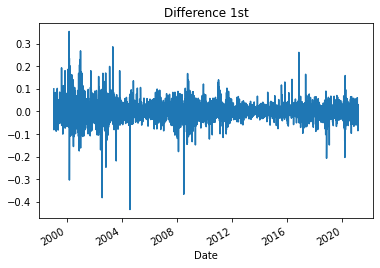

In [10]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

## 13.6 ARIMA 모델 훈련과 테스트

### 13.6.1 ARIMA 모델 빌드, 훈련

In [11]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 5507
Model:                 ARIMA(1, 1, 0)   Log Likelihood               10130.339
Method:                       css-mle   S.D. of innovations              0.038
Date:                Thu, 04 Mar 2021   AIC                         -20254.678
Time:                        15:29:33   BIC                         -20234.837
Sample:                             1   HQIC                        -20247.758
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0010      0.001      2.013      0.044    2.73e-05       0.002
ar.L1.D.Close     0.0020      0.013      0.148      0.882      -0.024       0.028
                                    Root

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A 

### 13.6.2 모델 테스트 및 플로팅

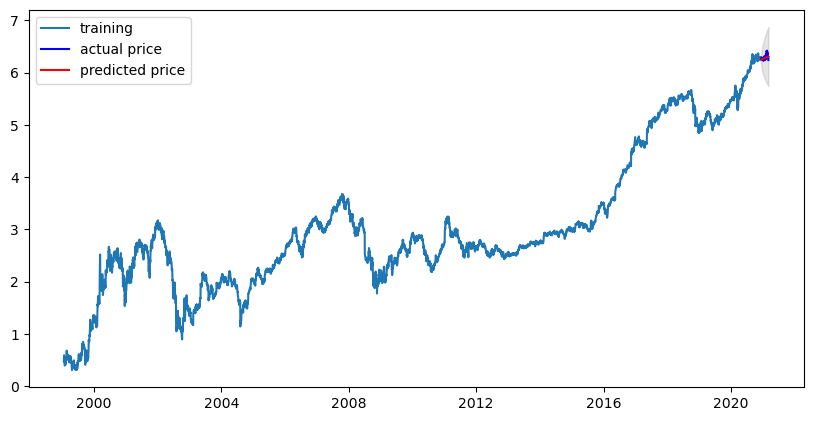

In [12]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

### 13.6.3 최종 예측 모델 정확도 측정(MAPE)

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  623.2478537526649
MAE:  17.505818364314763
RMSE:  24.96493248043473
MAPE: 3.10%


1. nomal -> 27.17%
2. train : test = 99 : 1  -> 3.10%  
기존 test셋 비율로 따졌을때 예측해야할 범위가 약 2년가량으로 너무 방대하여 예측이 잘 되지 않았던것으로 사료, 예측 범위를 축소시킴.


---

## 13.1 시계열 데이터 준비(AMD)

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/AMD.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
1980-03-17    3.145833
1980-03-18    3.031250
1980-03-19    3.041667
1980-03-20    3.010417
1980-03-21    2.916667
Name: Close, dtype: float64

## 13.2 각종 전처리 수행

### 13.2.1 결측치 처리

In [15]:
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

### 13.2.2 로그변환

In [16]:
ts_log = np.log(ts)

## 13.3 시계열 안정성 분석
-정성적 그래프 분석  
-정량적 Augmented Dicky-Fuller Test  
-시계열 분해(Time Series Decomposition)  
-Residual 안정성 확인

### 13.3.1 정성적 그래프 분석

In [17]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

### 13.3.2 정량적 Augmented Dicky-Fuller Test

In [18]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

### 13.3.3 시계열 분해 그래프 분석

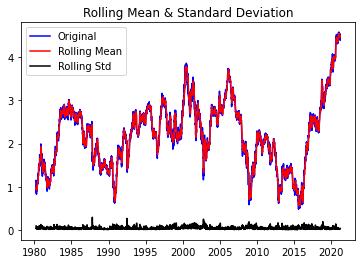

Results of Dickey-Fuller Test:
Test Statistic                    -2.050036
p-value                            0.265074
#Lags Used                         7.000000
Number of Observations Used    10321.000000
Critical Value (1%)               -3.430984
Critical Value (5%)               -2.861820
Critical Value (10%)              -2.566919
dtype: float64


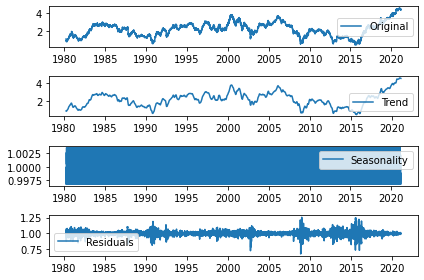

In [19]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### 13.3.4 Residual 안정성 확인

In [20]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                   -24.080413
p-value                            0.000000
#Lags Used                        35.000000
Number of Observations Used    10263.000000
Critical Value (1%)               -3.430987
Critical Value (5%)               -2.861822
Critical Value (10%)              -2.566920
dtype: float64


## 13.4 학습, 테스트 데이터셋 생성

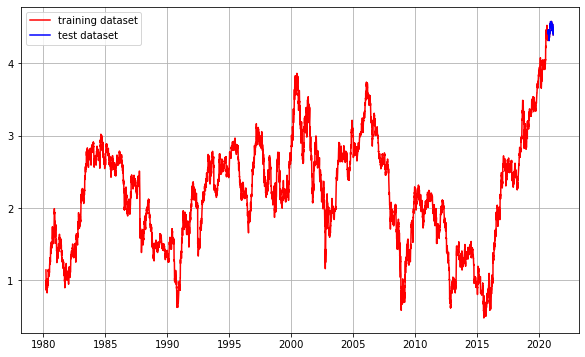

In [21]:
#학습, 테스트 데이터셋 분리

train_data, test_data = ts_log[:int(len(ts_log)*0.99)], ts_log[int(len(ts_log)*0.99):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 13.5 적정ARIMA모수 찾기

### 13.5.1 ACF, PACF 그려보기(p,q구하기)

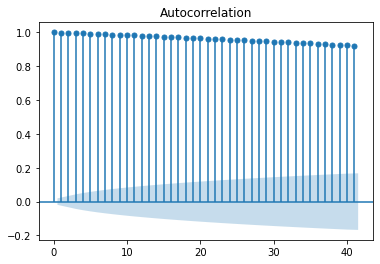

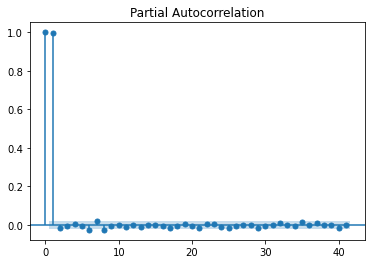

In [22]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### 13.5.2 차분 안정성 확인(d 구하기)

Results of Dickey-Fuller Test:
Test Statistic                   -37.803688
p-value                            0.000000
#Lags Used                         6.000000
Number of Observations Used    10321.000000
Critical Value (1%)               -3.430984
Critical Value (5%)               -2.861820
Critical Value (10%)              -2.566919
dtype: float64


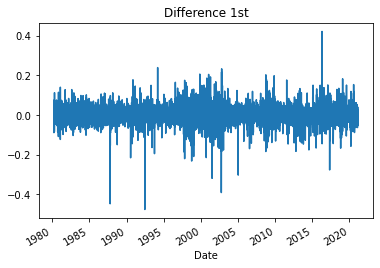

In [23]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

## 13.6 ARIMA 모델 훈련과 테스트

### 13.6.1 ARIMA 모델 빌드, 훈련

In [24]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                10224
Model:                 ARIMA(1, 1, 0)   Log Likelihood               18959.799
Method:                       css-mle   S.D. of innovations              0.038
Date:                Thu, 04 Mar 2021   AIC                         -37913.598
Time:                        15:29:35   BIC                         -37891.901
Sample:                             1   HQIC                        -37906.262
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.000      0.854      0.393      -0.000       0.001
ar.L1.D.Close     0.0076      0.010      0.765      0.444      -0.012       0.027
                                    Root

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A 

### 13.6.2 모델 테스트 및 플로팅

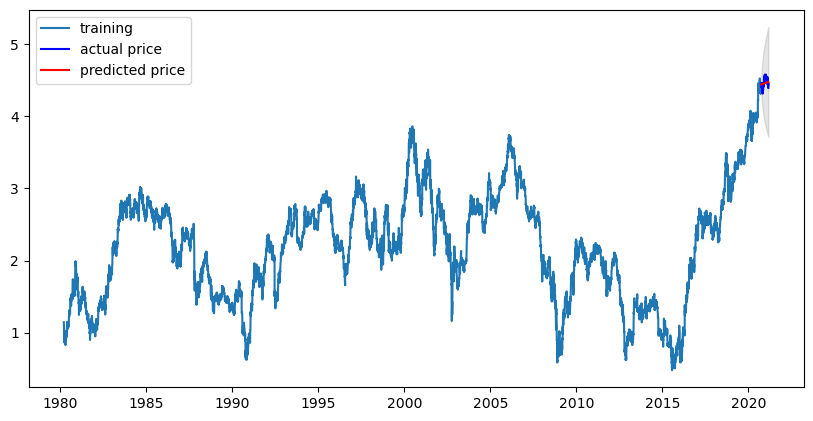

In [25]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

### 13.6.3 최종 예측 모델 정확도 측정(MAPE)

In [26]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  27.37284923696634
MAE:  4.343878209207175
RMSE:  5.231906845211059
MAPE: 4.93%


---

## 13.1 시계열 데이터 준비(Nintendo)

In [27]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

dataset_filepath = os.getenv('HOME') + '/aiffel/stock_prediction/data/NTDOY.csv'
df = pd.read_csv(dataset_filepath, index_col='Date', parse_dates=True)
ts = df['Close']

ts.head()

Date
1996-11-18    9.0000
1996-11-19    9.0000
1996-11-20    9.0625
1996-11-21    9.0000
1996-11-22    9.1250
Name: Close, dtype: float64

## 13.2 각종 전처리 수행

### 13.2.1 결측치 처리

In [28]:
ts=ts.interpolate(method='time')
ts[ts.isna()]  # Time Series에서 결측치가 있는 부분만 Series로 출력합니다. 

Series([], Name: Close, dtype: float64)

### 13.2.2 로그변환

In [29]:
ts_log = np.log(ts)

## 13.3 시계열 안정성 분석
-정성적 그래프 분석  
-정량적 Augmented Dicky-Fuller Test  
-시계열 분해(Time Series Decomposition)  
-Residual 안정성 확인

### 13.3.1 정성적 그래프 분석

In [30]:
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    

### 13.3.2 정량적 Augmented Dicky-Fuller Test

In [31]:
from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    

### 13.3.3 시계열 분해 그래프 분석

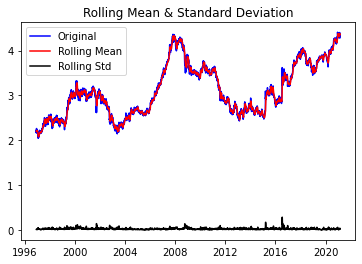

Results of Dickey-Fuller Test:
Test Statistic                   -1.231146
p-value                           0.660056
#Lags Used                       17.000000
Number of Observations Used    6094.000000
Critical Value (1%)              -3.431424
Critical Value (5%)              -2.862014
Critical Value (10%)             -2.567023
dtype: float64


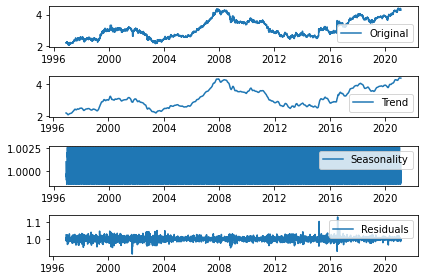

In [32]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

### 13.3.4 Residual 안정성 확인

In [33]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                  -20.605017
p-value                           0.000000
#Lags Used                       32.000000
Number of Observations Used    6049.000000
Critical Value (1%)              -3.431432
Critical Value (5%)              -2.862018
Critical Value (10%)             -2.567024
dtype: float64


## 13.4 학습, 테스트 데이터셋 생성

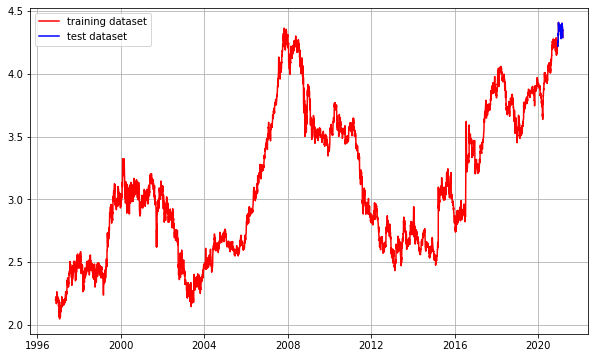

In [34]:
#학습, 테스트 데이터셋 분리

train_data, test_data = ts_log[:int(len(ts_log)*0.99)], ts_log[int(len(ts_log)*0.99):]
plt.figure(figsize=(10,6))
plt.grid(True)
plt.plot(ts_log, c='r', label='training dataset')  # train_data를 적용하면 그래프가 끊어져 보이므로 자연스러운 연출을 위해 ts_log를 선택
plt.plot(test_data, c='b', label='test dataset')
plt.legend()

## 13.5 적정ARIMA모수 찾기

### 13.5.1 ACF, PACF 그려보기(p,q구하기)

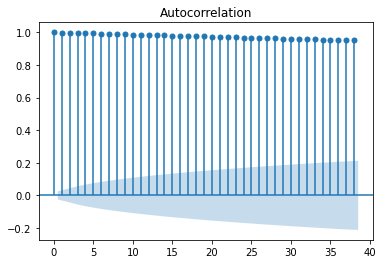

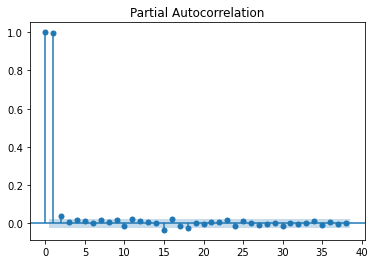

In [35]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

### 13.5.2 차분 안정성 확인(d 구하기)

Results of Dickey-Fuller Test:
Test Statistic                  -19.074410
p-value                           0.000000
#Lags Used                       16.000000
Number of Observations Used    6094.000000
Critical Value (1%)              -3.431424
Critical Value (5%)              -2.862014
Critical Value (10%)             -2.567023
dtype: float64


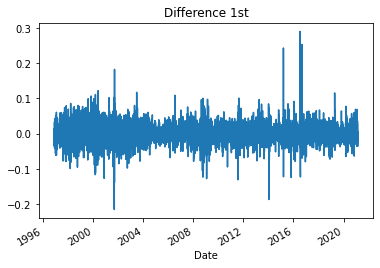

In [36]:
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

## 13.6 ARIMA 모델 훈련과 테스트

### 13.6.1 ARIMA 모델 빌드, 훈련

In [37]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1, 1, 0))  
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 6049
Model:                 ARIMA(1, 1, 0)   Log Likelihood               13240.593
Method:                       css-mle   S.D. of innovations              0.027
Date:                Thu, 04 Mar 2021   AIC                         -26475.186
Time:                        15:29:37   BIC                         -26455.063
Sample:                             1   HQIC                        -26468.201
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0003      0.000      1.025      0.305      -0.000       0.001
ar.L1.D.Close    -0.0616      0.013     -4.800      0.000      -0.087      -0.036
                                    Root

/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/arima_model.py:472: FutureWarning: 
statsmodels.tsa.arima_model.ARMA and statsmodels.tsa.arima_model.ARIMA have
been deprecated in favor of statsmodels.tsa.arima.model.ARIMA (note the .
between arima and model) and
statsmodels.tsa.SARIMAX. These will be removed after the 0.12 release.

statsmodels.tsa.arima.model.ARIMA makes use of the statespace framework and
is both well tested and maintained.

To silence this warning and continue using ARMA and ARIMA until they are
removed, use:

import warnings
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARMA',
                        FutureWarning)
warnings.filterwarnings('ignore', 'statsmodels.tsa.arima_model.ARIMA',
                        FutureWarning)

  warnings.warn(ARIMA_DEPRECATION_WARN, FutureWarning)
/home/aiffel-dj48/Downloads/aiffel/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:583: ValueWarning: A 

### 13.6.2 모델 테스트 및 플로팅

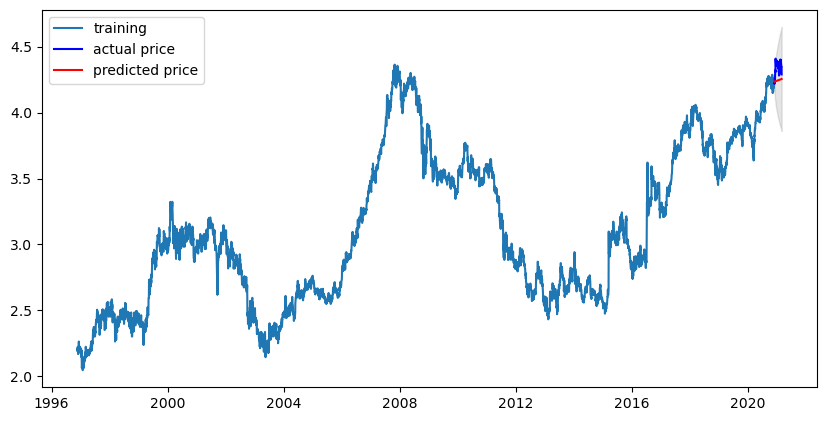

In [38]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

### 13.6.3 최종 예측 모델 정확도 측정(MAPE)

In [39]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  63.20794305944728
MAE:  7.222449613851902
RMSE:  7.950342323412702
MAPE: 9.21%


## 종류별 최종 MAPE
#### 엔비디아 : 3.10%
#### 암드 : 4.93%
#### 닌텐도 : 9.21%

# 느낀점

각 그래프가 나타내는 의미 파악하지 못함  
각 파라매터가 의미하는바 이해하지 못함  
그냥 너무 어렵네요.